# Instance Retrieval

### Importing files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import pandas as pd
from sklearn.cluster import MiniBatchKMeans as MBK
import pickle as pkl
import json
import glob
import os
from keras import applications
from keras.models import Model
from IPython.display import clear_output as clr
% matplotlib inline

Using TensorFlow backend.


In [2]:
files_dir = os.getcwd()+'/dataset_train/train'
list_folders = (os.listdir(files_dir))
n_classes = len(list_folders)

In [7]:
def get_model(img_rows, img_cols, channel=3):
    vgg_model = applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_rows, img_cols, channel))
    vgg_model.layers.pop()
    layer = vgg_model.layers[-1]
    model = Model(inputs=vgg_model.input, outputs=layer.output)
#     model.summary(line_length=150)
    return model
def read_and_format_image(img):
    resized_img = cv2.resize(img, (224, 224))
    return resized_img.reshape((1, 224, 224, 3))
def compute_feat_vectors(model , img):
    
    input_x = read_and_format_image(img)
    prediction = list(model.predict(input_x / 255).flatten().astype(float))
    
    return prediction

### Preprocessing

In [8]:
save_now = False  ## make true for first run
read = False ## make true if first run
if(save_now):
    data = []

    c_label = 0
    c_id = 0
    for folder in list_folders:
        folder_path = files_dir + '/' + folder
        print("Reading from folder ", folder)
        list_imgs = os.listdir(folder_path)
        for img_name in list_imgs:
            img = cv2.imread(folder_path+'/'+img_name)
            data_curr = [img, c_label, folder_path+'/'+img_name, c_id]
            c_id += 1
            data.append(data_curr)
        c_label += 1

    data_df = pd.DataFrame(data, columns = ['Image', 'label', 'name', 'id'])

    data_df.head()

    data_df.to_pickle("train.pkl")

else:
    if(read):
        data_df = pd.read_pickle("train.pkl")

### SIFT Features...

In [9]:
sift = cv2.xfeatures2d.SIFT_create()
model = get_model(224, 224, 3)

In [10]:
def mask(image):
    
    (h, w) = image.shape[:2]
    (cX, cY) = (int(w * 0.5), int(h * 0.5))
    (axesX, axesY) = (int(w * 0.5) // 2, int(h * 0.5) // 2)
    #ellipMask = np.zeros(image.shape, dtype = "uint8")
    ellipMask = np.zeros_like(image)
    cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
    ellipMask[:,:,1] = ellipMask[:,:,0]
    ellipMask[:,:,2] = ellipMask[:,:,0]
    masked_image = cv2.bitwise_and(image, ellipMask)
    
    return masked_image

In [11]:
load_pre = not read

if(not load_pre):
    data_final = []
    N, S = data_df.shape
    for i in range(N):
        c_data_i = data_df.iloc[i]
        c_im = c_data_i['Image']
        c_gray = cv2.cvtColor(c_im,cv2.COLOR_BGR2RGB)
        c_dkp = sift.detectAndCompute(c_gray, None)
#         vgg_feat = compute_feat_vectors(model , c_gray)
#         c_mask = mask(c_gray)
#         c_dkp = sift.detectAndCompute(c_mask, None)
#         vgg_feat = compute_feat_vectors(model , c_mask)
        data_final.append([c_dkp[1], c_data_i['label'], c_data_i['id'], c_data_i['name']])
        

    data_processed = pd.DataFrame(data_final, columns = ['Image', 'label', 'id', 'name'])
    data_processed.to_pickle("train_pre.pkl")
else:
    data_processed = pd.read_pickle("train_pre.pkl")
    vgg_data = pd.read_pickle("train_pre_vgg.pkl")

In [12]:
### preparing the data for hierarchical clustering
load_c_data = True ## make true if first run
if(not load_c_data):
    features = None
    labels = None
    ids = None
    vggs = None
    N, S = data_processed.shape
    for i in range(N):
        c_data_i = data_processed.iloc[i]
        if(features is None):
            features = c_data_i['Image']
            labels =  [c_data_i['label']]*c_data_i['Image'].shape[0]
            ids = [c_data_i['id']]*c_data_i['Image'].shape[0]
#             vggs = [c_data_i['Vgg']]*c_data_i['Image'].shape[0]
        else:
            features = np.concatenate([features, c_data_i['Image']])
            labels = np.concatenate([labels,  [c_data_i['label']]*c_data_i['Image'].shape[0]])
            ids = np.concatenate([ids,  [c_data_i['id']]*c_data_i['Image'].shape[0]])
#             vggs = np.concatenate([vggs,  [c_data_i['Vgg']]*c_data_i['Image'].shape[0]]) 

    np.save("features.npy", features)
    np.save("labels.npy", labels)
    np.save("ids.npy", ids)
#     np.save("vggs.npy", vggs)
else:
    features = np.load("features.npy")
    labels = np.load("labels.npy")
    ids = np.load("ids.npy")
#     vggs = np.load("vggs.npy")

In [13]:
vgg_trn_arr = []
vgg_feats_trn = vgg_data['Vgg'].values
for vgg_feat in vgg_feats_trn:
    vgg_trn_arr.append(vgg_feat)

vgg_trn_arr = np.array(vgg_trn_arr)

In [55]:
def get_img_prop(img,N):
    probs = np.zeros((N))
    vgg_feat = compute_feat_vectors(model , img)
    ids_trn = data_processed['id'].values  
    
    
    
    dists = np.linalg.norm(vgg_trn_arr - np.array(vgg_feat), axis =1)
    probs = dists
    
    
    prob_exp = np.exp(-probs)
    probs_norm = prob_exp/np.sum(prob_exp)
    
    for i in range(16):
        probs_norm[i*216:(i+1)*216] = np.max(probs_norm[i*216:(i+1)*216])
    
    return probs_norm

### Doing the clustering....

In [15]:
save_kmeans = False
if(save_kmeans):
    k_model = MBK(n_clusters = 5000, init_size = 100000, verbose = 1, n_init = 3, batch_size=50000)

    k_model.fit(features)

    with open("kmeans_model.pkl", 'wb') as file:  
        pkl.dump(k_model, file)

# Load from file
with open("kmeans_model.pkl", 'rb') as file:  
    k_model = pkl.load(file)

In [16]:
save_svm_data = False
if(save_svm_data):
    vecs = []
    for i in range(3456):
        vec = np.zeros((5000))
        img_feats = data_processed.iloc[i]['Image']
        c_ids = k_model.predict(img_feats)
        aa = np.unique(c_ids, return_counts = True)
        vec[aa[0]] = aa[1]
        print(vec.max(), i)
        vecs.append(np.array(vec))

    vecs_2 = np.array(vecs)

    y_t = [0]*216
    for i in range(1,16):
        y_t.extend([i]*216)

    np.save("vecs.npy", vecs_2)
    np.save("y_t.npy", y_t)

vecs_2 = np.load("vecs.npy")
y_t = np.load("y_t.npy")

In [17]:
from sklearn.svm import SVC

In [40]:
save_svm = False
if(save_svm):
    t_model = SVC(probability = True, max_iter = 100)
    t_model.fit(vecs_2, y_t)
    print(t_model.score(vecs_2, y_t))
    with open("svm_model.pkl", 'wb') as file:  
        pkl.dump(t_model, file)

# Load from file
with open("svm_model.pkl", 'rb') as file:  
    t_model = pkl.load(file)

In [41]:
def get_img_prop2(img,N):
    probs = np.zeros((N))
    
    vec = np.zeros((5000))
    c_im = img
    c_gray = cv2.cvtColor(c_im,cv2.COLOR_BGR2RGB)
    c_dkp = sift.detectAndCompute(c_gray, None)
    img_feats = c_dkp[1]
    c_ids = k_model.predict(img_feats)
    
    aa = np.unique(c_ids, return_counts = True)
    for j in range(aa[0].shape[0]):
        vec[aa[0][j]] = vec[aa[1][j]]

    probs_norm = np.exp(t_model.predict_log_proba(vec.reshape(1,-1)))
    
    return probs_norm

In [42]:
# data_feats = model.predict(features)

N = len(np.unique(ids))

In [43]:
create_inv_dict = False
if(create_inv_dict):
    inv_dict = {}

    for i in range(data_feats.shape[0]):
        index = ids[i]
        img_df = data_processed.iloc[index]
        img_id = img_df['id']
        cluster_id = data_feats[i]

        if(cluster_id in inv_dict.keys()):
            inv_dict[cluster_id].append(img_id)
        else:
            inv_dict[cluster_id] = [img_id]

    np.save("inv_dict.npy", inv_dict)
    
inv_dict = np.load("inv_dict.npy").item()

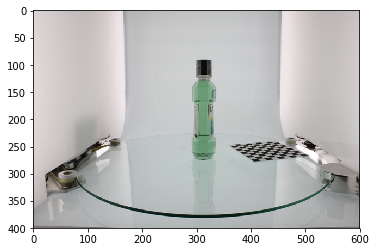

Computing label assignment and total inertia


4983

In [62]:
'''
Sample Query Image and for visulaization
'''


query = data_processed.iloc[2000]

feats = query['Image']

q_img = cv2.imread(query['name'])
q_img.shape

plt.imshow(cv2.cvtColor(q_img,cv2.COLOR_BGR2RGB))
plt.show()

feats.shape

c_vals = k_model.predict(feats)

scores = np.zeros((N))

len(inv_dict.keys())

In [63]:
pr = get_img_prop(q_img, N)

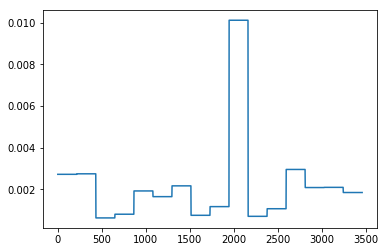

In [64]:
plt.plot(pr)

In [77]:
for c_val in c_vals:
    for doc_id in inv_dict[c_val]:
        scores[doc_id] += 1*pr[doc_id]



np.argmax(scores), query['id']

max_ids = np.argsort(scores)[::-1]

# max_ids[0:25]

act_img = data_processed.iloc[query['id']]['name']
print(act_img)
print("---------")
count = 0
for img_id in max_ids[0:20]:
    img_name = data_processed.iloc[img_id]['name']
#     if(("3m_high_tack_spray_adhesive") in img_name):
#         count+=1
    print(img_name)
# print(count)

/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N1_273.jpg
---------
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_147.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_234.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_27.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_33.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_57.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_237.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_150.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_144.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/listerine_green/N2_54.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/trai

In [78]:
def solve_query(img, data_size, method = "VGG"):
    
    # multiple window checking
    kernels = [ 
        [350,350,30,50],
        [100,100,40,50],
        [200,100,30,50]
    ]
    
    scores = np.zeros((data_size))
    if(method == "VGG"):
        func = get_img_prop
    elif(method == "SVM"):
        func = get_img_prop2
    else:
        func = None
        
    if(func is not None):
        pr = func(img, data_size)
    else:
        pr = np.ones((data_size))
        
        
    for kernel in kernels:
    
#     kernel = [390,390,10,10] # [N_v ,M_h ,S_v, S_h]


        D1, D2, C = img.shape
        N = int(np.ceil((D1-kernel[0])/(kernel[2]) + 1))
        M = int(np.ceil((D2-kernel[1])/(kernel[3]) + 1))


        not_match = 0
        for i in range(N-1):
            for j in range(M-1):
                v_u = i*kernel[2]
                v_l = min(v_u + kernel[0], D1)
                h_u = j*kernel[3]
                h_l = min(h_u + kernel[1], D2)
                
                
                pa_im = img[v_u:v_l,h_u:h_l,:]
                c_im = pa_im
                c_gray =  cv2.cvtColor(c_im,cv2.COLOR_BGR2RGB)
                
                try:
                    c_dkp = sift.detectAndCompute(c_gray, None)
                    feats = c_dkp[1]
                    if(len(feats)>30):
                        c_vals = k_model.predict(feats)
                        for c_val in c_vals:
                            if c_val in inv_dict.keys():
                                for doc_id in inv_dict[c_val]:
                                    scores[doc_id] += 1*pr[doc_id]
                            else:
                                not_match+=1
                    else:
                        pass
                except:
                    pass

                
    return scores

In [79]:
### Sample Visualization

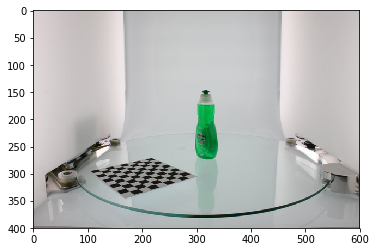

In [80]:
img = cv2.imread('/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/sample_test/test_1.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [81]:
vec = solve_query(img, 3456, method= "VGG")

Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing label assignment and total inertia
Computing 

In [82]:
max_ids = np.argsort(vec)[::-1]
for img_id in max_ids[:25]:
    img_name = data_processed.iloc[img_id]['name']
    print(img_name)

/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_216.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_138.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_213.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_132.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_111.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_210.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_15.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_219.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_144.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmolive_green/N2_186.jpg
/media/Drivef/Study/Mtech 2nd Sem/Vision/ass1/dataset_train/train/palmo

### Testing part only for TAs 

In [520]:
read_folder = "sample_test"
write_folder = "preds_test"


for img_path in os.listdir(read_folder):
    try:
        text_file = open(write_folder+'/'+img_path+".txt", "w")
        txt = ""
        img = cv2.imread(read_folder+'/'+img_path)
        print(img_path)
        vec = solve_query(img, 3456)
        max_ids = np.argsort(vec)[::-1]
        for img_id in max_ids:
            img_name = data_processed.iloc[img_id]['name']
            txt = "_".join(img_name.split("/")[-2:])+"\n"
            text_file.write(txt)
            txt = ""
        text_file.close()
        clr()
    except:
        pass